In [1]:
from pathlib import Path
import pandas as pd
from rodent_loss_src.rnaseq import read_oma, parse_rnaseq, find_significant
import numpy as np


ORGANISMS = ["human", "mouse"]
MIRNAS = ["mir197", "mir769"]
PROJECTDIR = Path('.').resolve().parents[2]
oma_path = '../data/human_mouse_omapairwise.txt'
in_path = '../data/{}_results_Neg_vs_{}.tsv'

vulcano_path = f'{PROJECTDIR}/publication/revision/vulcanoplot.pdf'

In [2]:
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)


def filter_low_expressed(df, minT):
    """
    Filters for minimum number of reads in the negative Control and minimum amount of log2Fold-Change (positive as well as negative). 
    Then re-calculates the adjusted p-value using Benjamini-Hochberg and then filters for minimum p-adjusted
    """
    def calc_FDR(pvals):
        reject, padj, alphacSidak, alphacBonf = multipletests(pvals, alpha=0.05, method='fdr_bh')
        return padj
    
    df = df[df['bMctrl'] >= minT]
    # df = df[(df['log2FoldChange'] > fT) | (df['log2FoldChange'] < -fT)]
    df['padj'] = calc_FDR(df['pvalue'].values)
    # df = df[df['padj'] <= float(pT)]

    return df




def prepare_vulcanoplot(in_path, pairwise):
    col = {}
    for organism in ORGANISMS:
        for mirna in MIRNAS:
            condition = organism + '|' + mirna
            df = parse_rnaseq(in_path.format(organism, mirna), pairwise, organism, mirna)
            # print(df.index.size)
            df = filter_low_expressed(df, minT=100)
            col[condition] = df
    return col


pairwise = read_oma(oma_path)
condition2df = prepare_vulcanoplot(in_path, pairwise)




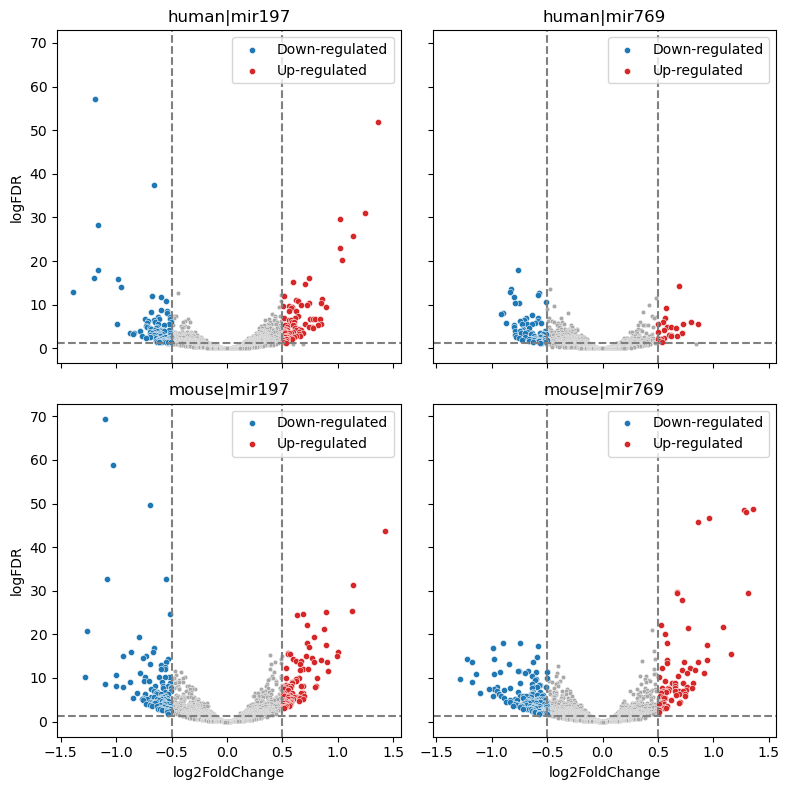

In [3]:

def make_vulcanoplot(condition2df):
    min_foldchange = 0.5
    min_FDR = 0.05
    log_min_FDR = -np.log10(min_FDR)

    positions = [[0,0], [0,1], [1,0], [1,1]]
    axnumber = 0
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True, sharex=True)
    for condition, df in condition2df.items():
        df = df.filter(['gene', 'log2FoldChange', 'padj'])
        df['logFDR'] = df.padj.apply(lambda x:-np.log10(x))

        down = df[(df['log2FoldChange']<=-min_foldchange)&(df['padj']<=min_FDR)]
        up = df[(df['log2FoldChange']>=min_foldchange)&(df['padj']<=min_FDR)]

        x,y = positions[axnumber]
        sns.scatterplot(data=df, x='log2FoldChange', y='logFDR', ax=ax[x,y], s=10, color='darkgrey')
        sns.scatterplot(data=down, x='log2FoldChange', y='logFDR', ax=ax[x,y], s=20, color='tab:blue', label="Down-regulated")
        sns.scatterplot(data=up, x='log2FoldChange', y='logFDR', ax=ax[x,y], s=20, color='tab:red', label="Up-regulated")

        ax[x,y].axvline(-min_foldchange,color="grey",linestyle="--")
        ax[x,y].axvline(min_foldchange,color="grey",linestyle="--")
        ax[x,y].axhline(log_min_FDR,color="grey",linestyle="--")

        ax[x,y].set_title(condition)
        
        plt.tight_layout()
        axnumber += 1
    
    plt.savefig(vulcano_path)


make_vulcanoplot(condition2df)

In [4]:
plt.figure(figsize=(3, 4))
plt.scatter(x=df['log2FoldChange'],y=df['padj'].apply(lambda x:-np.log10(x)),s=1, color='darkgrey')
plt.xlabel("log2FoldChange")
plt.ylabel("-logFDR")
plt.axvline(-0.5,color="grey",linestyle="--")
plt.axvline(0.5,color="grey",linestyle="--")
plt.axhline(-np.log10(0.05),color="grey",linestyle="--")

# highlight down- or up- regulated genes
down = df[(df['log2FoldChange']<=-0.5)&(df['padj']<=0.05)]
up = df[(df['log2FoldChange']>=0.5)&(df['padj']<=0.05)]

plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="tab:blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="tab:red")
plt.title(f'{mirna} - {organism}')
plt.legend()
plt.tight_layout()

NameError: name 'df' is not defined

<Figure size 300x400 with 0 Axes>